In [2]:
!cp /content/drive/MyDrive/Colab\ Notebooks/include/data_utils.py /content/
#TODO: remove the below 'prerequisites' after cleaning up data_utils
!cp /content/drive/MyDrive/Colab\ Notebooks/include/tuning_utils.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/include/models.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/include/sca_utils.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/include/data_utils.py /content/
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
def sbox_val(x):
    # your SBOX as np.array of 256
    from sca_utils import SBOX
    return SBOX[x]

In [6]:
H5_PROF = f"/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_datasets/profiling_windows/byte_15.h5"

import h5py

try:
  profiling_file = h5py.File(H5_PROF, 'r')
except Exception as e:
  print(f"NO: {e}")

In [7]:
pt_vals = profiling_file['metadata/plaintexts'][:]   # shape (N,)
key_val = profiling_file['metadata/key'][()]         # scalar
labels  = profiling_file['labels'][:]                # shape (N,)

In [12]:
import numpy as np
from sca_utils import SBOX

expected_labels = SBOX[pt_vals ^ key_val]

In [13]:
mismatches = np.sum(expected_labels != labels)
print(f"Mismatches: {mismatches} / {len(labels)}")


Mismatches: 0 / 25001


In [5]:
# ATTACK set check

import numpy as np
import h5py
from sca_utils import SBOX

# Load attack data
attack_h5_path = "/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_datasets/attack_windows/byte_15.h5"
with h5py.File(attack_h5_path, "r") as hf:
    labels = hf["labels"][:]
    pts = hf["metadata/plaintexts"][:]   # shape (num_samples,)
    full_key = hf["metadata/key"][:]  # shape (16,)
    key_byte = full_key[15]

# Recompute labels from pt and key
computed_labels = SBOX[np.bitwise_xor(pts, key_byte)]

# Compare
mismatches = np.sum(computed_labels != labels)
print(f"Mismatches: {mismatches} / {len(labels)}")


Mismatches: 0 / 2501


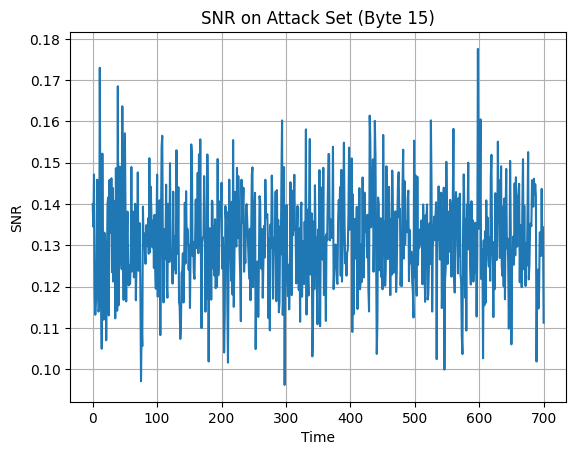

In [9]:
def compute_snr_chunked(traces_h5, labels_h5, byte_index, chunk_size=5000, num_classes=256, epsilon=1e-9):
    """
    Computes SNR in chunks to avoid loading the entire dataset into memory.

    Args:
        traces_h5: The HDF5 dataset object for traces.
        labels_h5: The HDF5 dataset object for labels.
        byte_index: The key byte (0-15) to analyze.
        chunk_size: How many traces to process at a time.
    """
    num_traces, trace_length = traces_h5.shape

    # Initialize arrays to accumulate statistics
    mean = np.zeros((num_classes, trace_length))
    var = np.zeros((num_classes, trace_length))
    cpt = np.zeros(num_classes, dtype=int)

    # Process the data in chunks
    for i in range(0, num_traces, chunk_size):
        # Slice a chunk from the HDF5 file (this is memory-efficient)
        traces_chunk = traces_h5[i:i+chunk_size]
        # Get the labels for the target byte
        labels_chunk = labels_h5[i:i+chunk_size]

        # Accumulate statistics for this chunk
        for c in range(num_classes):
            # Find all traces in the chunk that correspond to class 'c'
            class_traces = traces_chunk[labels_chunk == c]
            if class_traces.shape[0] > 0:
                mean[c] += np.sum(class_traces, axis=0)
                var[c] += np.sum(class_traces**2, axis=0)
                cpt[c] += class_traces.shape[0]

    # Calculate the final mean and variance
    for c in range(num_classes):
        if cpt[c] > 0:
            mean[c] /= cpt[c]
            var[c] = (var[c] / cpt[c]) - (mean[c]**2)

    # Avoid division by zero
    var[np.abs(var) < epsilon] = epsilon

    # Calculate the final SNR
    var_of_means = np.var(mean, axis=0)
    mean_of_vars = np.mean(var, axis=0)

    return var_of_means / mean_of_vars

# Load attack traces and labels
with h5py.File("/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_datasets/attack_windows/byte_15.h5", "r") as f:
    traces = f["windows"][:, 0, :]  # shape: (2501, 701) for window 0
    labels = f["labels"][:]

snr = compute_snr_chunked(traces, labels, 15)

# Plot
import matplotlib.pyplot as plt
plt.plot(snr)
plt.title("SNR on Attack Set (Byte 15)")
plt.xlabel("Time")
plt.ylabel("SNR")
plt.grid()
plt.show()


In [10]:
with h5py.File("/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_datasets/attack_windows/byte_15.h5", "r") as f:
    print("rin shape:", f['metadata/masks_rin'].shape)
    print("rout shape:", f['metadata/masks_rout'].shape)
    print("rin sample:", f['metadata/masks_rin'][:10])
    print("rout sample:", f['metadata/masks_rout'][:10])

rin shape: (2501, 1)
rout shape: (2501, 1)
rin sample: [[172]
 [ 51]
 [207]
 [ 51]
 [ 33]
 [ 15]
 [134]
 [ 57]
 [178]
 [170]]
rout sample: [[197]
 [ 35]
 [244]
 [111]
 [127]
 [196]
 [ 76]
 [159]
 [ 77]
 [242]]


In [16]:
with h5py.File("/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_datasets/attack_mbedtls_masked_20250909_223527.h5", "r") as f:
    print("Datasets inside raw file:")
    def print_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"  - {name}: shape {obj.shape}, dtype {obj.dtype}")
    f.visititems(print_structure)

Datasets inside raw file:
  - annotations_idcs: shape (41,), dtype uint32
  - annotations_names: shape (41,), dtype object
  - hashes: shape (2501, 3), dtype uint8
  - key: shape (16,), dtype int64
  - labels: shape (2501, 16), dtype uint8
  - masks_rin: shape (2501, 1), dtype uint8
  - masks_rout: shape (2501, 1), dtype uint8
  - plaintexts: shape (2501, 16), dtype uint8
  - prands: shape (2501,), dtype uint32
  - traces: shape (2501, 4732), dtype float64


In [18]:
RAW_H5_PATH = "/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_datasets/attack_mbedtls_masked_20250909_223527.h5"
BYTE = 15

with h5py.File(RAW_H5_PATH, "r") as f:
    pts = f["plaintexts"][:, BYTE]
    key = f["key"][BYTE]
    rout = f["masks_rout"][:, 0]
    raw_labels = f["labels"][:, BYTE]

# Try reconstructing masked and unmasked labels
true_labels = SBOX[np.bitwise_xor(pts, key)]
masked_labels = np.bitwise_xor(true_labels, rout)
mismatch_count = np.sum(raw_labels != masked_labels)

print(f"Mismatches (raw vs masked): {mismatch_count} / {len(raw_labels)}")

Mismatches (raw vs masked): 2494 / 2501


In [19]:
from sca_utils import SBOX
import numpy as np
import h5py

BYTE = 15

with h5py.File(RAW_H5_PATH, "r") as f:
    labels_raw = f["labels"][:, BYTE]
    pt = f["plaintexts"][:, BYTE]
    key = f["key"][BYTE]
    rin = f["masks_rin"][:, 0]
    rout = f["masks_rout"][:, 0]

# 1. Try expected unmasked label
expected = SBOX[np.bitwise_xor(pt, key)]
print("Unmasked matches:", np.sum(labels_raw == expected))

# 2. Try ASCAD-style masking (SBOX[PT ⊕ K] ⊕ rout)
masked_ascad = np.bitwise_xor(expected, rout)
print("ASCAD-style matches:", np.sum(labels_raw == masked_ascad))

# 3. Try SBOX[PT ⊕ rin] ⊕ rout (input masking)
masked_input = np.bitwise_xor(SBOX[np.bitwise_xor(pt, rin)], rout)
print("Input-masked matches:", np.sum(labels_raw == masked_input))

# 4. Try SBOX[(PT ⊕ K) ⊕ rin] ⊕ rout (composite mask — very rare)
composite = np.bitwise_xor(SBOX[np.bitwise_xor(np.bitwise_xor(pt, key), rin)], rout)
print("Composite masked matches:", np.sum(labels_raw == composite))

# 5. Print sample values
print("\nFirst 5 rows:")
print("PT     :", pt[:5])
print("Key    :", key)
print("Rin    :", rin[:5])
print("Rout   :", rout[:5])
print("Label  :", labels_raw[:5])
print("SBOX(PT⊕K):", expected[:5])
print("Masked :", masked_ascad[:5])


Unmasked matches: 2501
ASCAD-style matches: 7
Input-masked matches: 11
Composite masked matches: 15

First 5 rows:
PT     : [253 102   3  51 102]
Key    : 6
Rin    : [172  51 207  51  33]
Rout   : [197  35 244 111 127]
Label  : [ 15 208 107 150 208]
SBOX(PT⊕K): [ 15 208 107 150 208]
Masked : [202 243 159 249 175]
